In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import malaya
import random
import re
import string
from pprint import pprint
from statistics import mean
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

sia = SentimentIntensityAnalyzer()
mly = malaya.sentiment.multinomial()

malay_stopwords = np.load('data/malay_stopwords.npy')
positive_malay_words = np.load('data/positive_malay_words.npy')
negative_malay_words = np.load('data/negative_malay_words.npy')

unwanted = nltk.corpus.stopwords.words("english")
unwanted.extend(malay_stopwords)

def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if not word.isalpha() or word in unwanted:
        return False
    #if tag.startswith("NN"):
        #return False
    if word in string.punctuation:
        return False
    return True

df = pd.read_csv('datasets/duck_training.csv')
df = df.replace(-1, 'negative')
df = df.replace(0, 'neutral')
df = df.replace(1, 'positive')
df = df[df['TweetSentiment'] != 'neutral']

df2 = pd.read_csv('datasets/student_tweet_training.csv')

df3 = pd.read_csv('datasets/malay_dataset_twitter_training.csv')
df3 = df3[df3['TweetSentiment'] != 'neutral']

dfs = [df, df2, df3]
df = pd.concat(dfs, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True) #shuffles the dataframe

tweets_df = df['TweetText']
positive_tweets = np.array(tweets_df[df['TweetSentiment'] == 'positive'])
negative_tweets = np.array(tweets_df[df['TweetSentiment'] == 'negative'])
tweets = np.concatenate((positive_tweets, negative_tweets))

positive_words = []
for positive_tweet in positive_tweets :
    #removes hyperlinks and twitter mentions
    positive_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', positive_tweet)
    positive_tweet = re.sub('(@[A-Za-z0-9_]+)','', positive_tweet)

    positive_tweet = positive_tweet.lower()
    positive_words.extend(nltk.pos_tag(nltk.word_tokenize(positive_tweet)))

positive_words_raw = [word for word, tag in positive_words]

positive_words = [word for word, tag in filter(
    skip_unwanted,
    positive_words)
]

negative_words = []
for negative_tweet in negative_tweets :
    #removes hyperlinks and twitter mentions
    negative_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', negative_tweet)
    negative_tweet = re.sub('(@[A-Za-z0-9_]+)','', negative_tweet)

    negative_tweet = negative_tweet.lower()
    negative_words.extend(nltk.pos_tag(nltk.word_tokenize(negative_tweet)))

negative_words_raw = [word for word, tag in negative_words]

negative_words = [word for word, tag in filter(
    skip_unwanted,
    negative_words)
]

learned_words = np.concatenate((positive_words, negative_words))
random.shuffle(learned_words)

positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)
common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]
    learned_words = np.delete(learned_words, np.where(learned_words == word))
    
positive_word_top_100 = [word for word, count in positive_fd.most_common(100)]
negative_word_top_100 = [word for word, count in negative_fd.most_common(100)]

#positive_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    #word for word in positive_words_raw
    #if word.isalpha() and word not in unwanted
#])

#negative_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    #word for word in negative_words_raw
    #if word.isalpha() and word not in unwanted
#])

#np.save('data/positive_word_top_100', positive_word_top_100)
#np.save('data/negative_word_top_100', negative_word_top_100)
#np.save('data/learned_words', learned_words)

def get_features(tweet):
    features = dict()
    top_positive_words_frequency = 0
    top_negative_words_frequency = 0
    positive_malay_words_frequency = 0
    negative_malay_words_frequency = 0
    english_compound_scores = list()
    english_positive_scores = list()
    english_negative_scores = list()
    malaya_positive_scores = list()
    malaya_negative_scores = list()

    word_tokens = set(nltk.word_tokenize(tweet))

    for sentence in nltk.sent_tokenize(tweet):
        #removes hyperlinks and twitter mentions
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', sentence)
        sentence = re.sub('(@[A-Za-z0-9_]+)','', sentence)

        for word in nltk.word_tokenize(sentence):
            if word.lower() in positive_word_top_100:
                top_positive_words_frequency += 1
            if word.lower() in negative_word_top_100:
                top_negative_words_frequency += 1
            if word.lower() in positive_malay_words:
                positive_malay_words_frequency += 1
            if word.lower() in negative_malay_words:
                negative_malay_words_frequency += 1
        
        malaya_positive_scores.append(mly.predict_proba([sentence])[0]["positive"])
        malaya_negative_scores.append(mly.predict_proba([sentence])[0]["negative"])

        english_compound_scores.append(sia.polarity_scores(sentence)["compound"])
        english_positive_scores.append(sia.polarity_scores(sentence)["pos"])
        english_negative_scores.append(sia.polarity_scores(sentence)["neg"])

    features["malaya_mean_positive"] = mean(malaya_positive_scores)
    features["malaya_mean_negative"] = mean(malaya_negative_scores)
    
    features["english_mean_compound"] = mean(english_compound_scores) + 1
    features["english_mean_positive"] = mean(english_positive_scores)
    features["english_mean_negative"] = mean(english_negative_scores)
    
    features["top_positive_words_frequency"] = top_positive_words_frequency
    features["top_negative_words_frequency"] = top_negative_words_frequency

    features["positive_malay_words_frequency"] = positive_malay_words_frequency
    features["negative_malay_words_frequency"] = negative_malay_words_frequency

    for word in learned_words:
        if word in word_tokens:
            features[F"contains({word})"] = 1
        else:
            features[F"contains({word})"] = 0

    return features

training_dataset = [
    (get_features(tweet), "positive")
    for tweet in positive_tweets
]
training_dataset.extend([
    (get_features(tweet), "negative")
    for tweet in negative_tweets
])

training_count = len(training_dataset) // 5
random.shuffle(training_dataset)

classifiers = {
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "SVMClassifier": SVC(),
}

for classifier_name, sklearn_classifier in classifiers.items():
    classifier = nltk.classify.SklearnClassifier(sklearn_classifier)

    print(F"\nTraining {classifier_name} model...")
    print(F"Training sample size: {len(training_dataset)-training_count}")
    classifier.train(training_dataset[:len(training_dataset)-training_count])

    print(F"Testing {classifier_name} model...")
    print(F"Testing sample size: {training_count}")
    accuracy = nltk.classify.accuracy(classifier, training_dataset[len(training_dataset)-training_count:])

    print(F"{classifier_name} - Accuracy: {accuracy:.2%}")
    pickle.dump(classifier, open(F"models/{classifier_name}.pickle", 'wb'))

c:\Users\User\anaconda3\envs\fyp3\lib\site-packages\malaya_boilerplate\frozen_graph.py:35: UserWarning: Cannot import beam_search_ops from Tensorflow Addons, ['malaya.jawi_rumi.deep_model', 'malaya.phoneme.deep_model', 'malaya.rumi_jawi.deep_model', 'malaya.stem.deep_model'] will not available to use, make sure Tensorflow Addons version >= 0.12.0
  warnings.warn(
c:\Users\User\anaconda3\envs\fyp3\lib\site-packages\malaya_boilerplate\frozen_graph.py:38: UserWarning: check compatible Tensorflow version with Tensorflow Addons at https://github.com/tensorflow/addons/releases
  warnings.warn(
c:\Users\User\anaconda3\envs\fyp3\lib\site-packages\malaya\tokenizer.py:202: FutureWarning: Possible nested set at position 3361
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))
c:\Users\User\anaconda3\envs\fyp3\lib\site-packages\malaya\tokenizer.py:202: FutureWarning: Possible nested set at position 3879
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))



Training MultinomialNB model...
Training sample size: 1414
Testing MultinomialNB model...
Testing sample size: 353
MultinomialNB - Accuracy: 82.72%

Training KNeighborsClassifier model...
Training sample size: 1414
Testing KNeighborsClassifier model...
Testing sample size: 353
KNeighborsClassifier - Accuracy: 75.92%

Training DecisionTreeClassifier model...
Training sample size: 1414
Testing DecisionTreeClassifier model...
Testing sample size: 353
DecisionTreeClassifier - Accuracy: 76.77%

Training RandomForestClassifier model...
Training sample size: 1414
Testing RandomForestClassifier model...
Testing sample size: 353
RandomForestClassifier - Accuracy: 77.34%

Training LogisticRegression model...
Training sample size: 1414
Testing LogisticRegression model...
Testing sample size: 353
LogisticRegression - Accuracy: 81.30%

Training MLPClassifier model...
Training sample size: 1414
Testing MLPClassifier model...
Testing sample size: 353
MLPClassifier - Accuracy: 83.57%

Training SVMCla

Multinomial NB 

Training Accuracy scores: [0.93064402 0.93772116 0.93352192 0.93140028 0.93422914]
Mean Training Accuracy: 93.35033048345782
Training Precision scores: [0.96296296 0.96950241 0.96031746 0.9616     0.96331738]
Mean Training Precision: 0.9635400430710188
Training Recall scores: [0.88855869 0.897474   0.89762611 0.89169139 0.89614243]
Mean Training Recall: 0.8942985260206082
Training F1 scores: [0.92426584 0.93209877 0.92791411 0.92532717 0.92851653]
Mean Training F1 Score: 0.9276244837420163
Validation Accuracy scores: [0.78531073 0.8079096  0.79886686 0.82152975 0.80453258]
Mean Validation Accuracy: 80.36299034906612
Validation Precision scores: [0.83453237 0.83892617 0.87596899 0.86206897 0.86131387]
Mean Validation Precision: 0.8545620749951611
Validation Recall scores: [0.68639053 0.73964497 0.67261905 0.74404762 0.70238095]
Mean Validation Recall: 0.7090166244012398
Validation F1 scores: [0.75324675 0.78616352 0.76094276 0.79872204 0.77377049]
Mean Validation F1 Sco

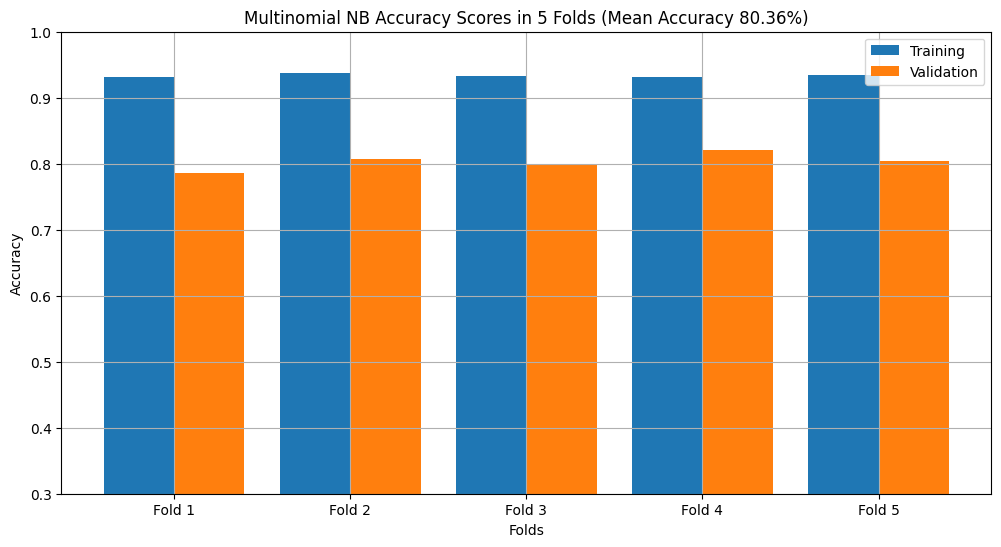

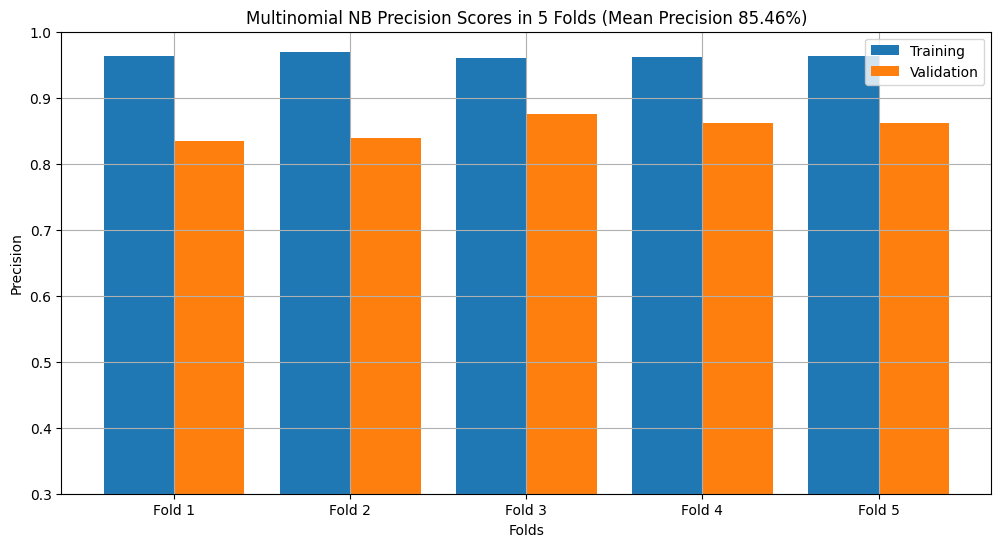

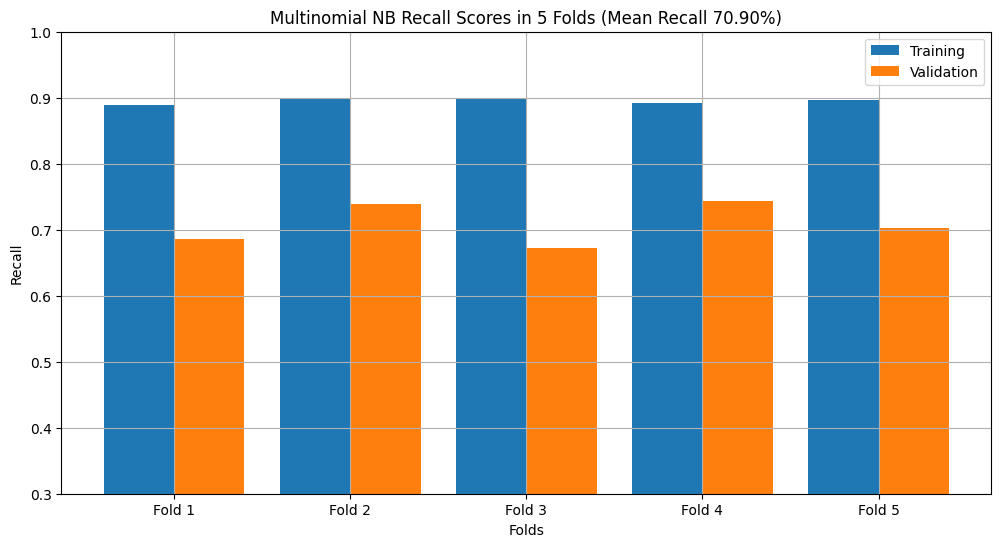

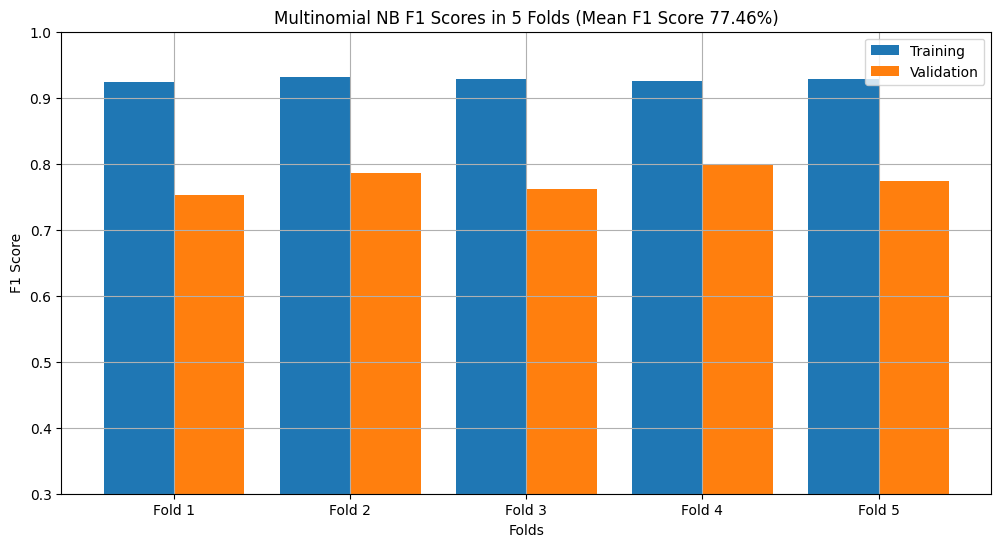

K Nearest Neighbors 

Training Accuracy scores: [0.82873319 0.8138712  0.8330976  0.8175389  0.80693069]
Mean Training Accuracy: 82.0034314623455
Training Precision scores: [0.81277213 0.81155015 0.82686567 0.79971182 0.80989181]
Mean Training Precision: 0.8121583162104997
Training Recall scores: [0.8320951  0.79346211 0.82195846 0.82344214 0.77744807]
Mean Training Recall: 0.8096811742452635
Training F1 scores: [0.82232012 0.80240421 0.82440476 0.81140351 0.79333838]
Mean Training F1 Score: 0.8107741951058038
Validation Accuracy scores: [0.74011299 0.75706215 0.75070822 0.71671388 0.73937677]
Mean Validation Accuracy: 74.07948016196923
Validation Precision scores: [0.72781065 0.73714286 0.74390244 0.68681319 0.7183908 ]
Mean Validation Precision: 0.7228119876931418
Validation Recall scores: [0.72781065 0.76331361 0.72619048 0.74404762 0.74404762]
Mean Validation Recall: 0.7410819949281489
Validation F1 scores: [0.72781065 0.75       0.73493976 0.71428571 0.73099415]
Mean Validation F1

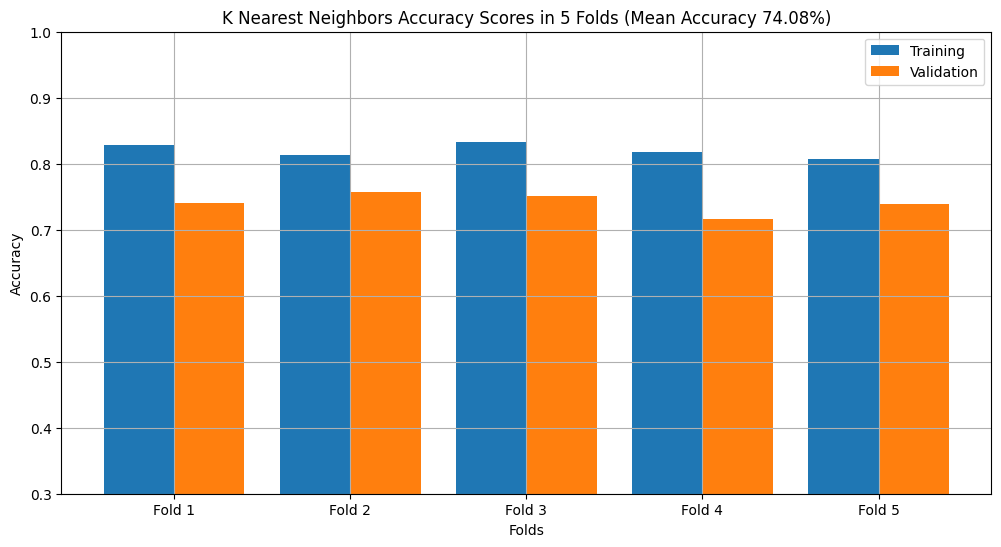

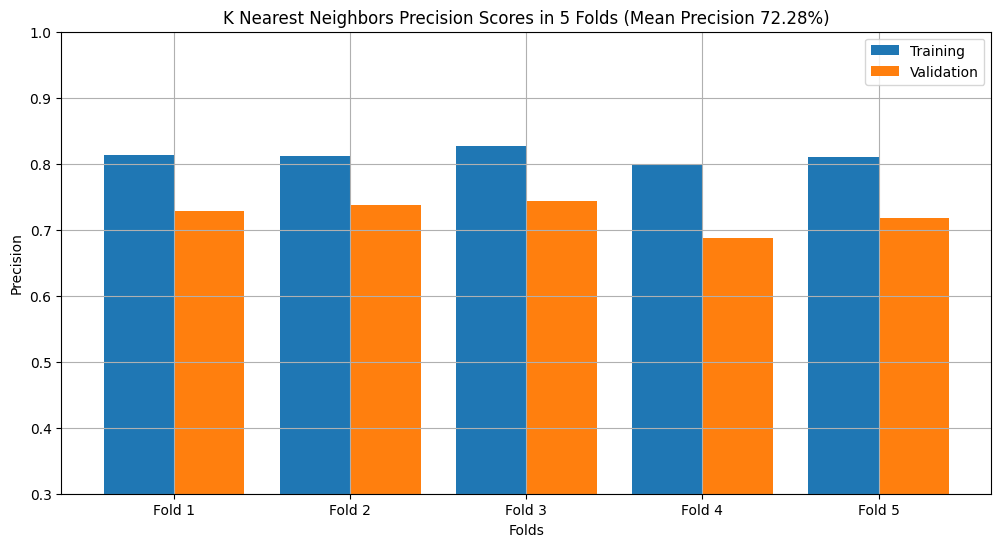

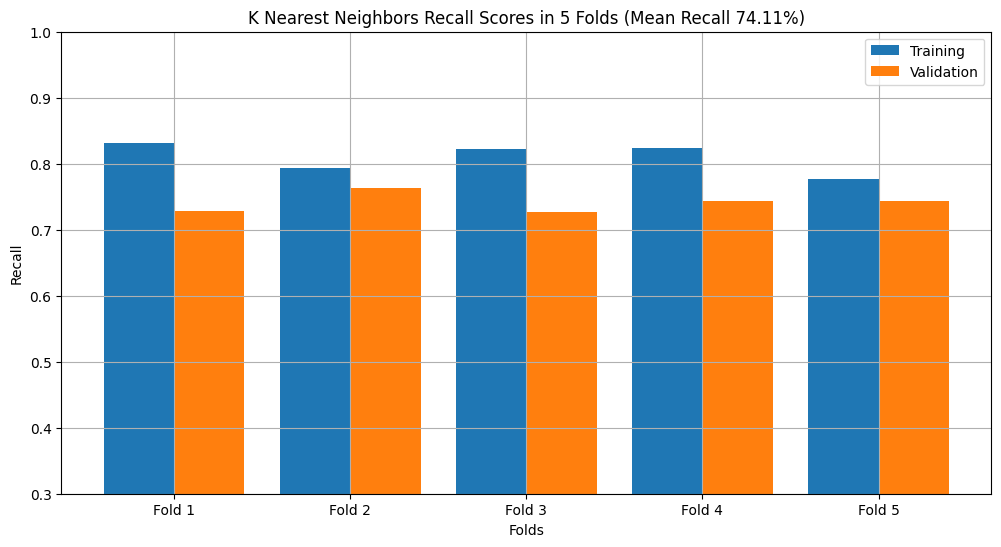

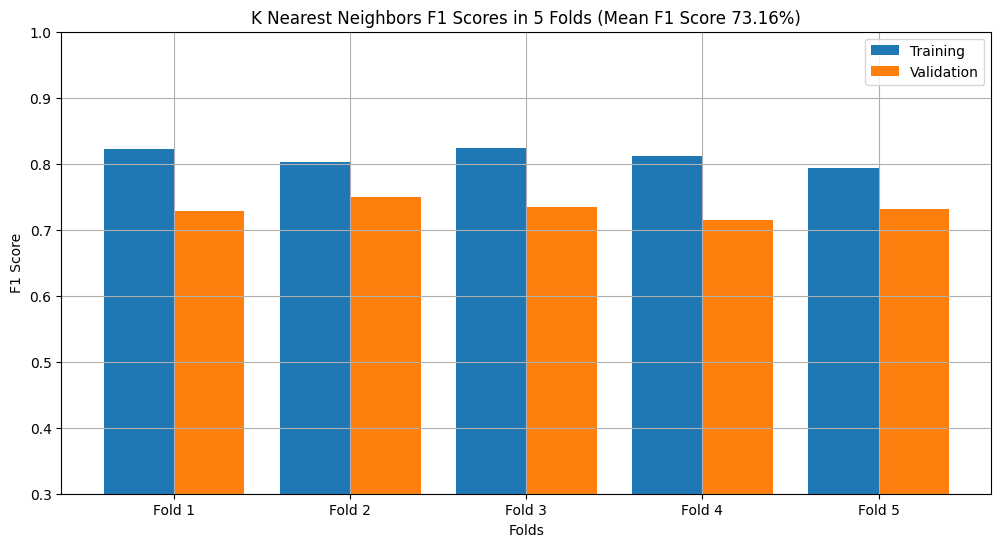

Decision Tree 

Training Accuracy scores: [0.99929229 0.99929229 0.99929279 1.         0.99929279]
Mean Training Accuracy: 99.94340289351958
Training Precision scores: [0.99851632 0.99851632 1.         1.         1.        ]
Mean Training Precision: 0.9994065281899109
Training Recall scores: [1.         1.         0.99851632 1.         0.99851632]
Mean Training Recall: 0.9994065281899109
Training F1 scores: [0.99925761 0.99925761 0.99925761 1.         0.99925761]
Mean Training F1 Score: 0.9994060876020787
Validation Accuracy scores: [0.72881356 0.79378531 0.73087819 0.76770538 0.76203966]
Mean Validation Accuracy: 75.66444199036508
Validation Precision scores: [0.71345029 0.79268293 0.72121212 0.7721519  0.75609756]
Mean Validation Precision: 0.7511189600297674
Validation Recall scores: [0.72189349 0.76923077 0.70833333 0.72619048 0.73809524]
Mean Validation Recall: 0.7327486615948156
Validation F1 scores: [0.71764706 0.78078078 0.71471471 0.74846626 0.74698795]
Mean Validation F1 Scor

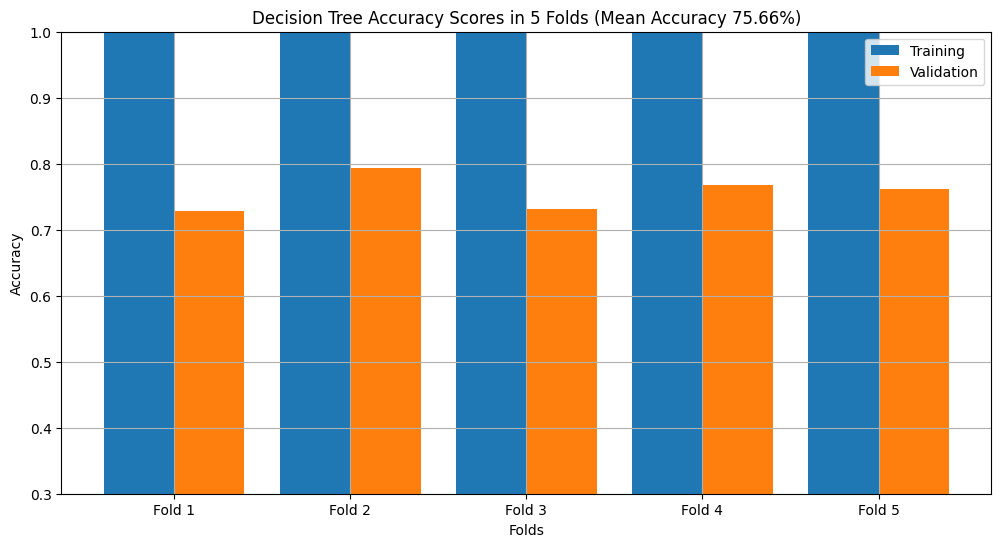

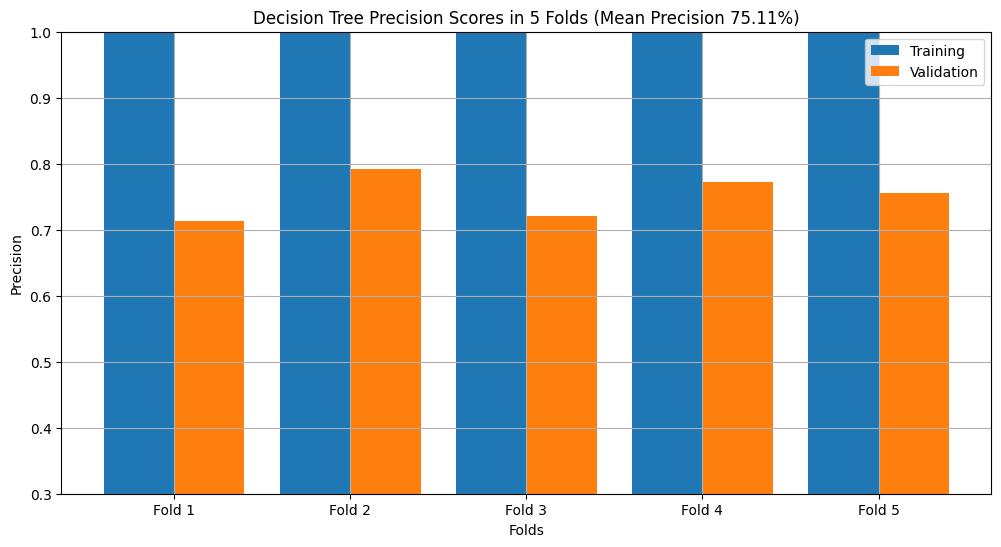

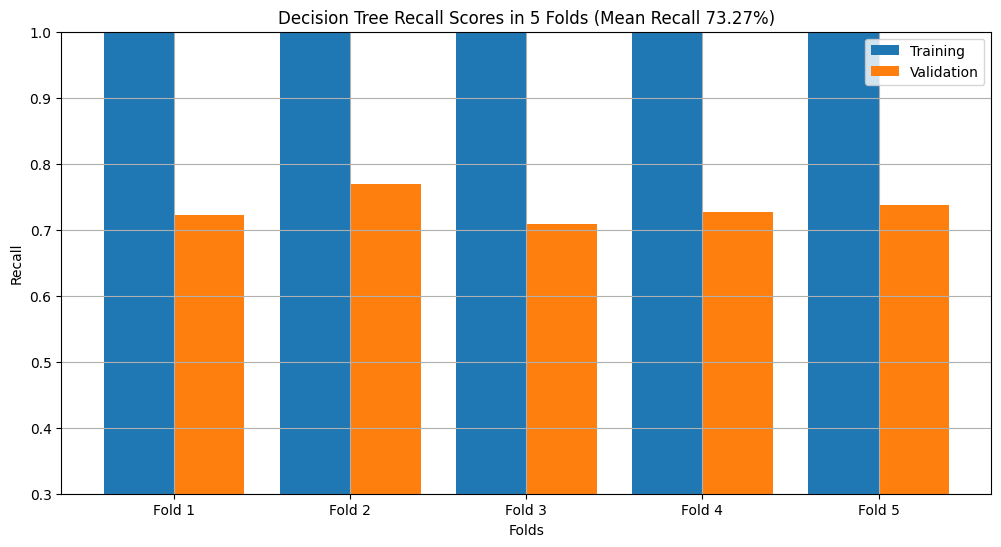

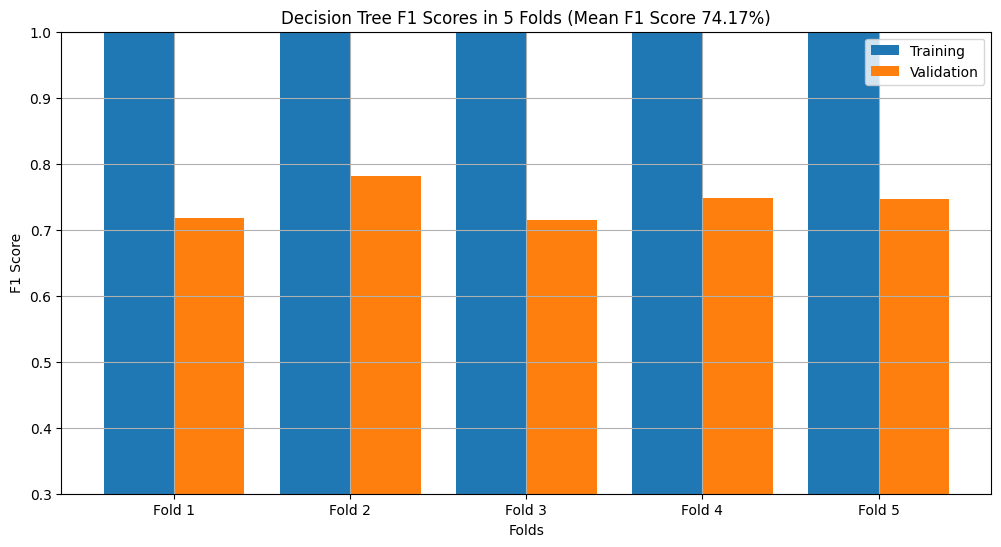

Random Forest 

Training Accuracy scores: [0.99929229 0.99929229 0.99929279 1.         0.99929279]
Mean Training Accuracy: 99.94340289351958
Training Precision scores: [0.99851632 0.99851632 0.99851852 1.         1.        ]
Mean Training Precision: 0.9991102318936147
Training Recall scores: [1.         1.         1.         1.         0.99851632]
Mean Training Recall: 0.9997032640949556
Training F1 scores: [0.99925761 0.99925761 0.99925871 1.         0.99925761]
Mean Training F1 Score: 0.9994063077326933
Validation Accuracy scores: [0.77683616 0.81073446 0.7592068  0.76770538 0.78470255]
Mean Validation Accuracy: 77.98370704694226
Validation Precision scores: [0.79605263 0.81481481 0.76100629 0.7654321  0.78395062]
Mean Validation Precision: 0.7842512903502642
Validation Recall scores: [0.71597633 0.78106509 0.7202381  0.73809524 0.75595238]
Mean Validation Recall: 0.7422654268808115
Validation F1 scores: [0.75389408 0.79758308 0.74006116 0.75151515 0.76969697]
Mean Validation F1 Scor

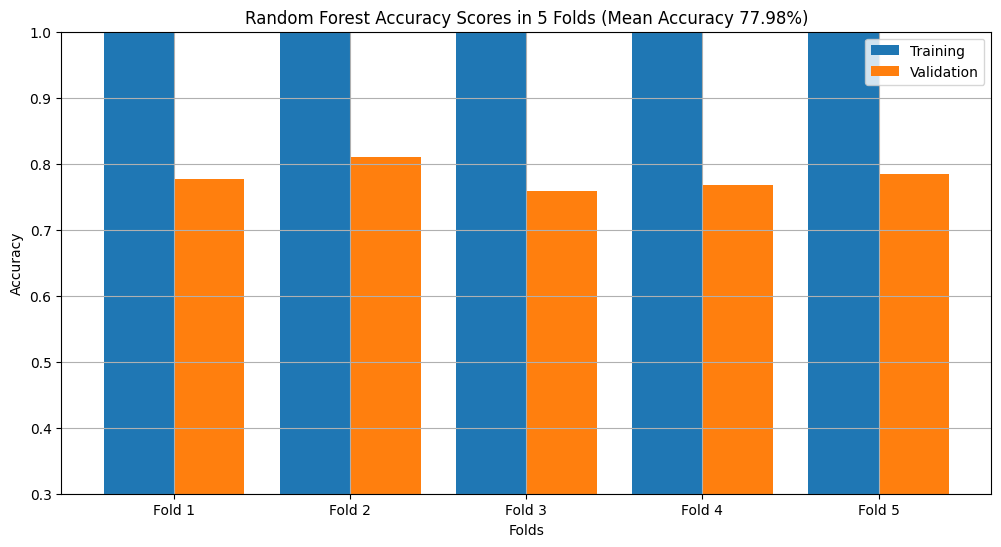

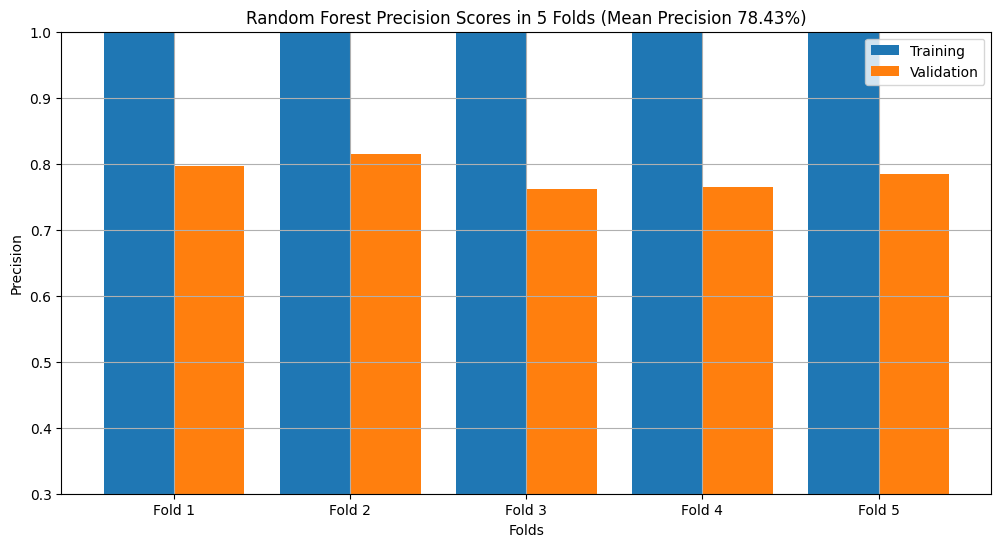

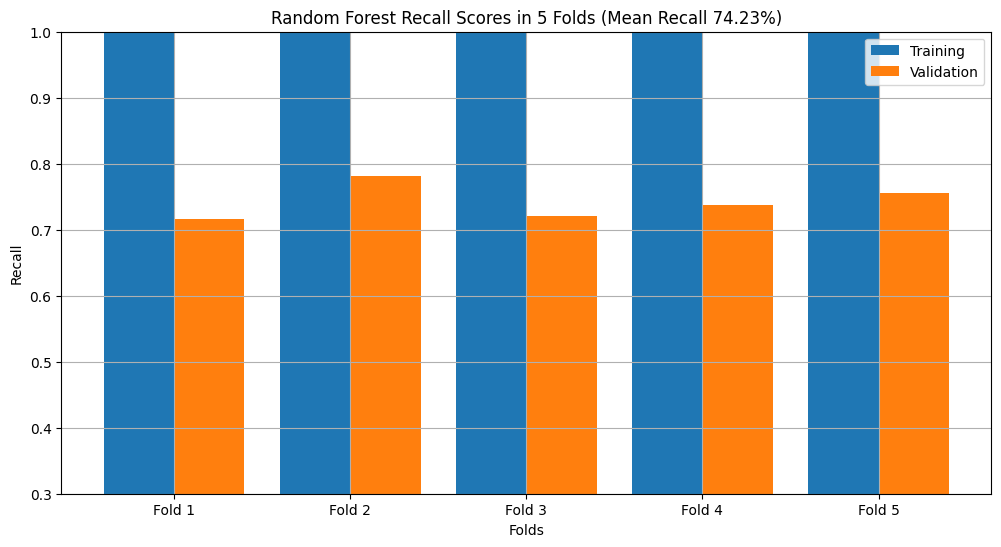

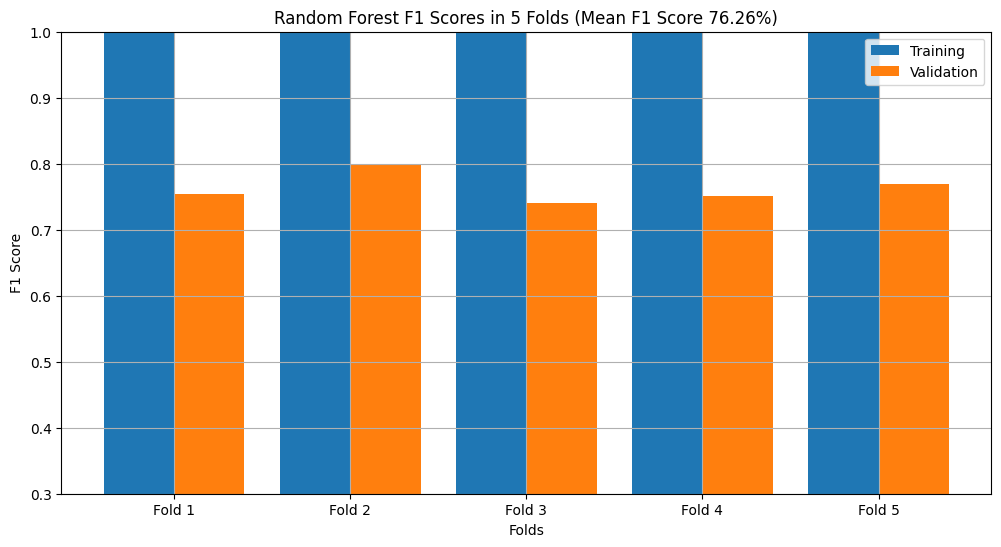

Logistic Regression 

Training Accuracy scores: [0.92215145 0.92710545 0.92291372 0.92362093 0.92079208]
Mean Training Accuracy: 92.33167265771162
Training Precision scores: [0.93108729 0.94392523 0.93394777 0.93538462 0.9376947 ]
Mean Training Precision: 0.9364079230340309
Training Recall scores: [0.90341753 0.90044577 0.90207715 0.90207715 0.89317507]
Mean Training Recall: 0.9002385351034607
Training F1 scores: [0.91704374 0.921673   0.91773585 0.918429   0.91489362]
Mean Training F1 Score: 0.9179550426948924
Validation Accuracy scores: [0.79378531 0.81355932 0.78186969 0.80736544 0.80736544]
Mean Validation Accuracy: 80.078903986812
Validation Precision scores: [0.79268293 0.81595092 0.78616352 0.8125     0.82051282]
Mean Validation Precision: 0.8055620379200132
Validation Recall scores: [0.76923077 0.78698225 0.74404762 0.77380952 0.76190476]
Mean Validation Recall: 0.7671949845026769
Validation F1 scores: [0.78078078 0.80120482 0.76452599 0.79268293 0.79012346]
Mean Validation F1 

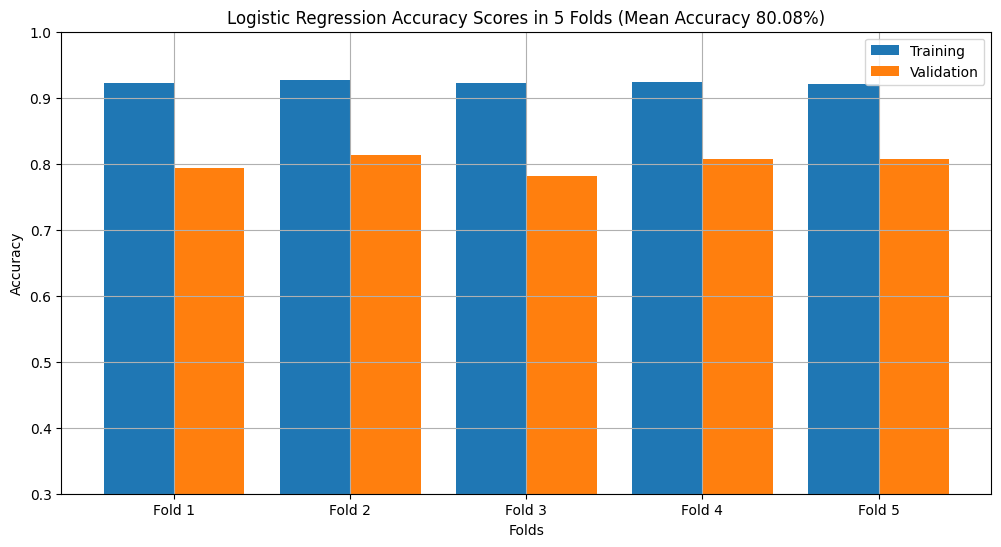

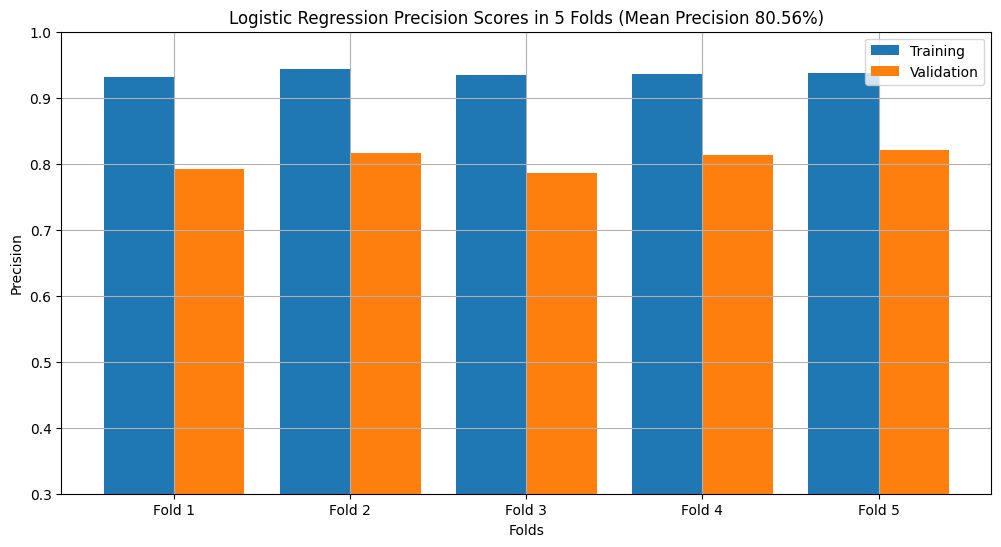

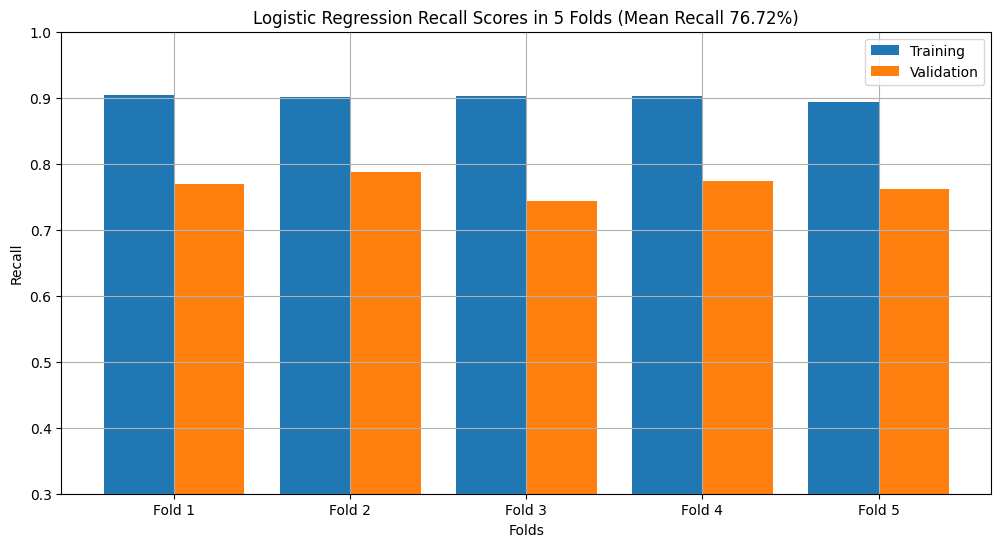

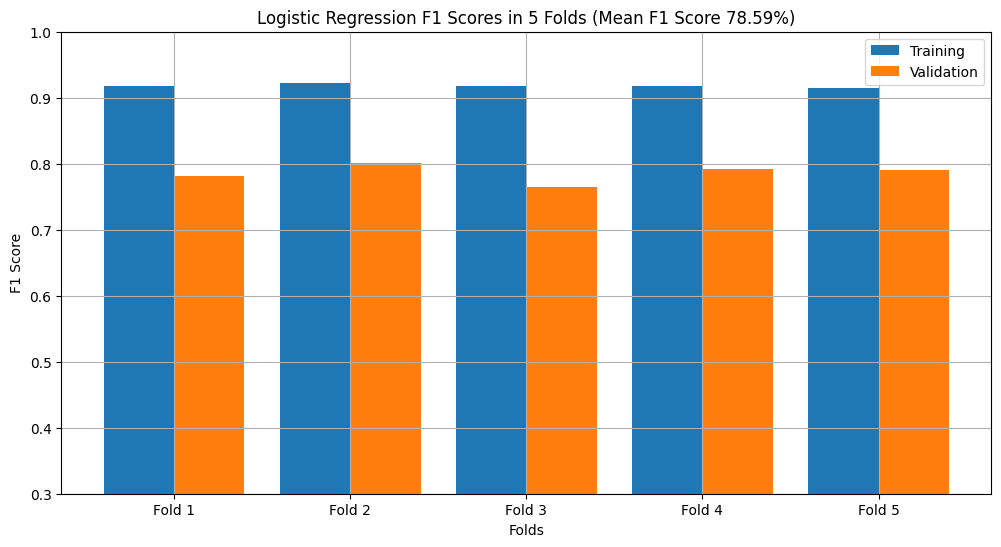

Multilayer Perceptron 

Training Accuracy scores: [0.94621373 0.95682944 0.94695898 0.94978784 0.95049505]
Mean Training Accuracy: 95.00570075205881
Training Precision scores: [0.9543379  0.96363636 0.96578538 0.94666667 0.95345345]
Mean Training Precision: 0.9567759528652603
Training Recall scores: [0.93164933 0.94502229 0.92136499 0.94807122 0.9421365 ]
Mean Training Recall: 0.9376488639820811
Training F1 scores: [0.94285714 0.95423856 0.94305239 0.94736842 0.94776119]
Mean Training F1 Score: 0.947055541875816
Validation Accuracy scores: [0.81073446 0.81920904 0.8101983  0.83002833 0.84985836]
Mean Validation Accuracy: 82.40056977321106
Validation Precision scores: [0.82278481 0.8343949  0.86861314 0.82926829 0.87581699]
Mean Validation Precision: 0.8461756278836582
Validation Recall scores: [0.76923077 0.77514793 0.70833333 0.80952381 0.79761905]
Mean Validation Recall: 0.7719709777402086
Validation F1 scores: [0.79510703 0.80368098 0.78032787 0.81927711 0.83489097]
Mean Validation 

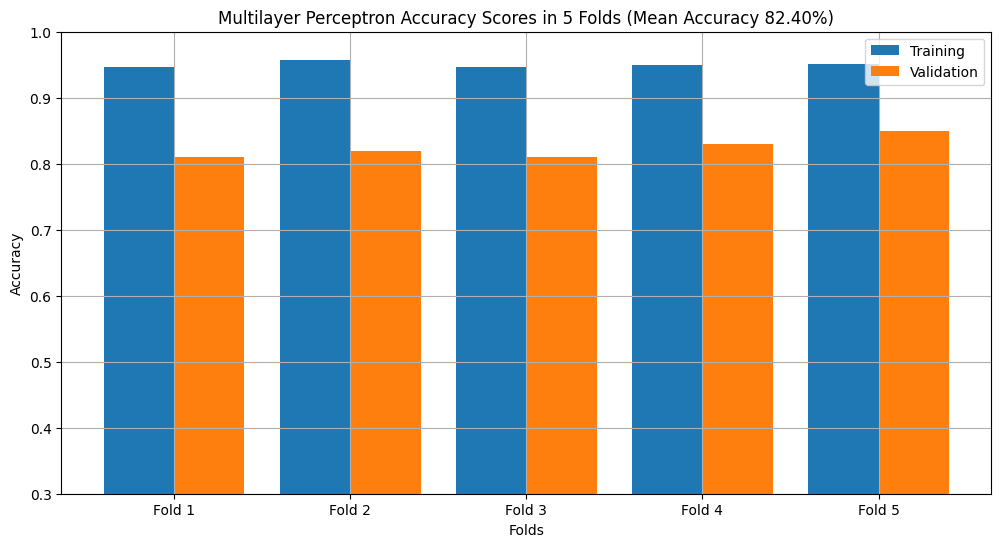

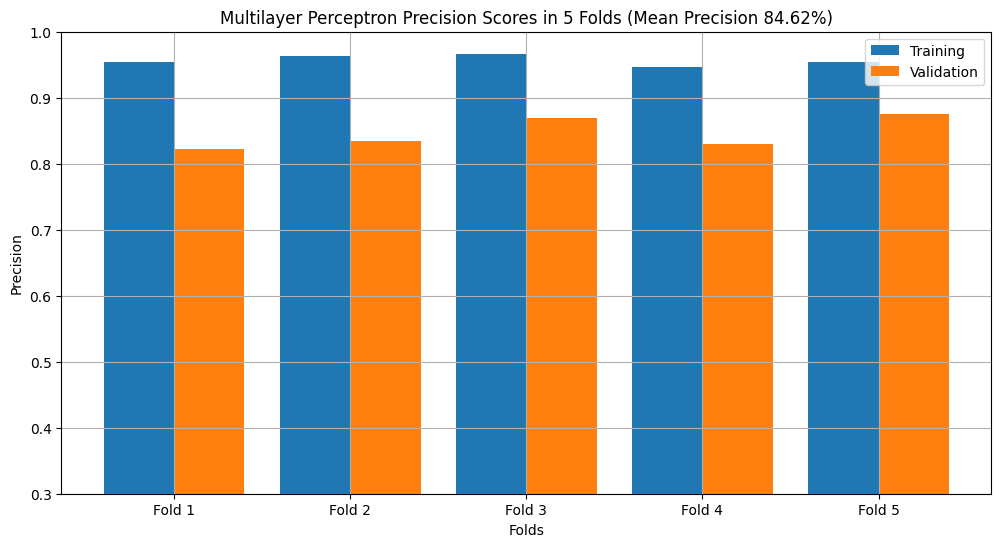

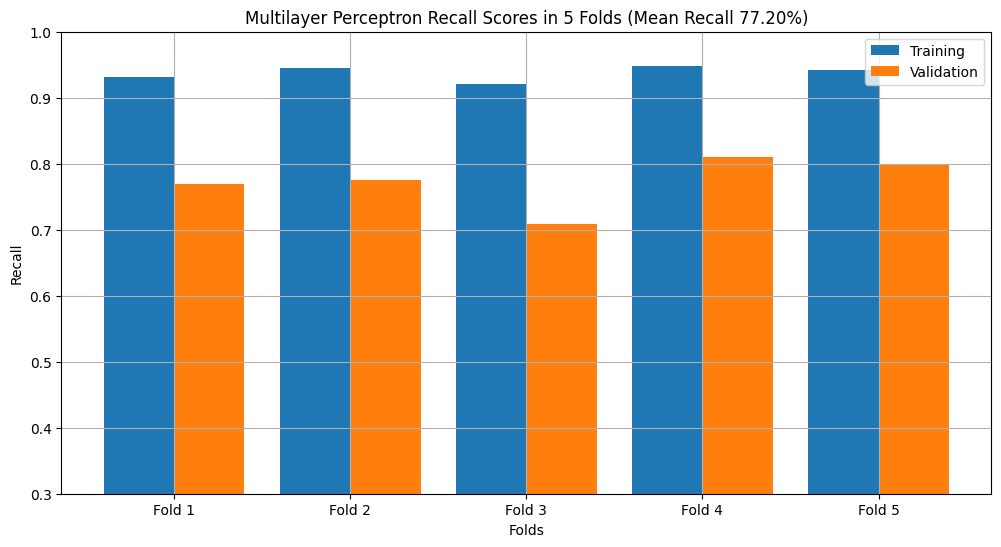

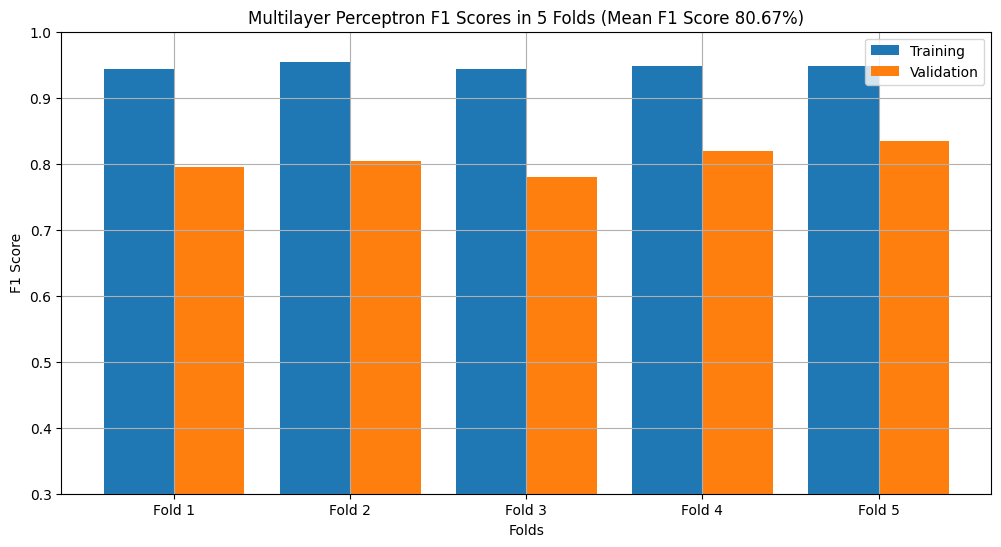

Support Vector Machine 

Training Accuracy scores: [0.88535032 0.89808917 0.88967468 0.9009901  0.88826025]
Mean Training Accuracy: 89.24729051613078
Training Precision scores: [0.91680261 0.9286872  0.92739274 0.92515924 0.93      ]
Mean Training Precision: 0.925608356233424
Training Recall scores: [0.83506686 0.85141159 0.83382789 0.8620178  0.82789318]
Mean Training Recall: 0.842043465416819
Training F1 scores: [0.87402799 0.88837209 0.878125   0.89247312 0.87598116]
Mean Training F1 Score: 0.8817958733554867
Validation Accuracy scores: [0.77683616 0.80225989 0.76487252 0.77903683 0.78753541]
Mean Validation Accuracy: 78.21081608809078
Validation Precision scores: [0.82142857 0.81528662 0.81481481 0.82608696 0.82517483]
Mean Validation Precision: 0.8205583584287546
Validation Recall scores: [0.68047337 0.75739645 0.6547619  0.67857143 0.70238095]
Mean Validation Recall: 0.6947168216398986
Validation F1 scores: [0.74433657 0.78527607 0.72607261 0.74509804 0.75884244]
Mean Validation 

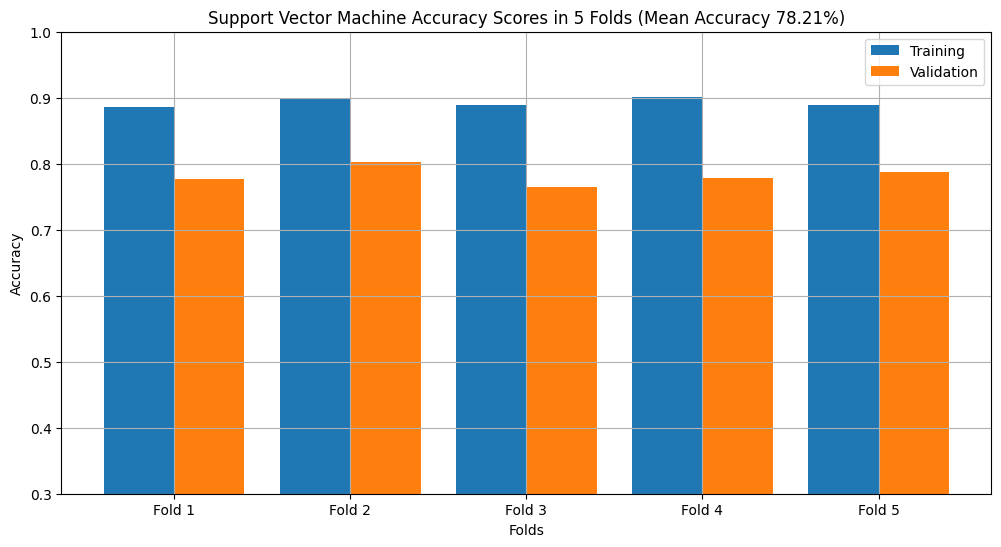

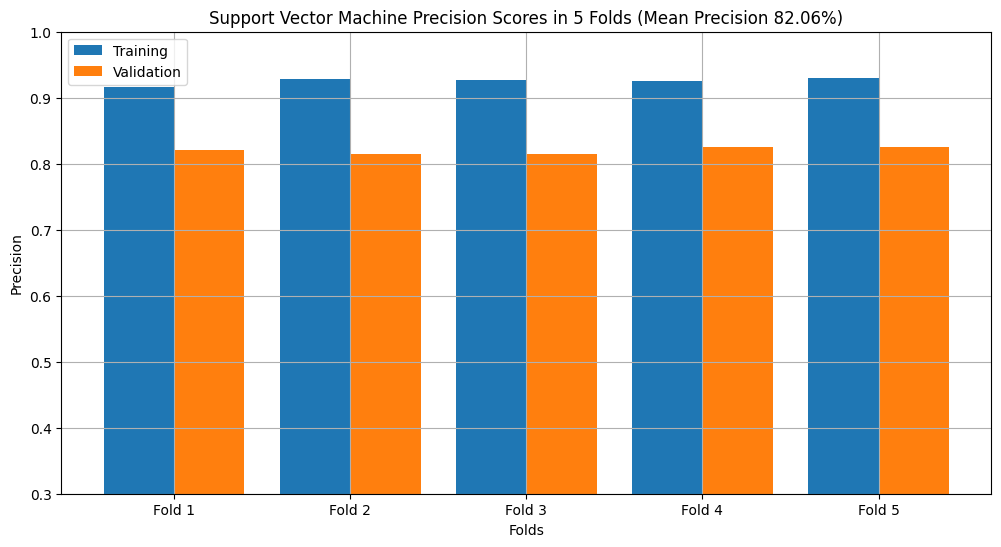

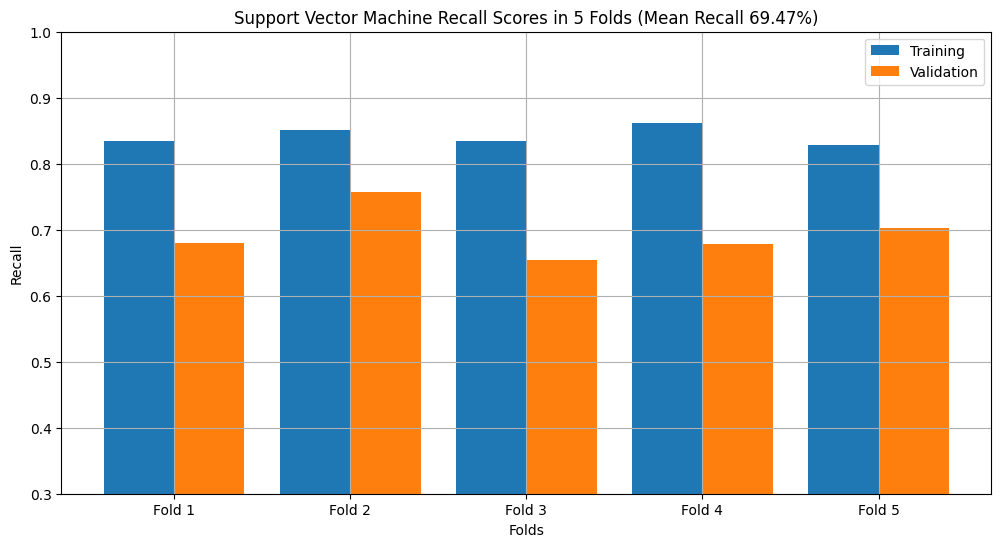

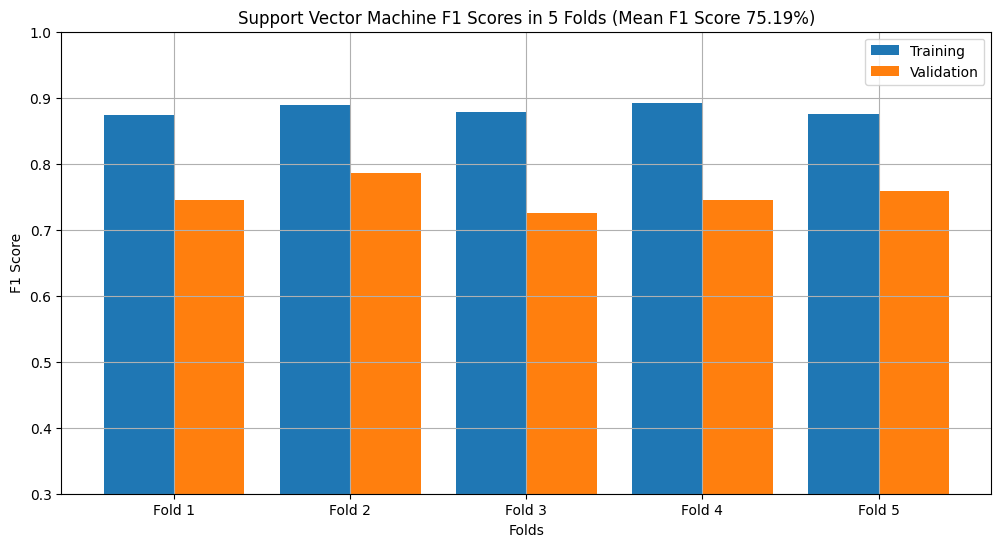

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def cross_validation(model, train_x, train_y, cv=5):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(
        estimator=model,
        X=train_x,
        y=train_y,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
      
    training_result = {
        "Training Accuracy scores": results['train_accuracy'],
        "Mean Training Accuracy": results['train_accuracy'].mean()*100,
        "Training Precision scores": results['train_precision'],
        "Mean Training Precision": results['train_precision'].mean(),
        "Training Recall scores": results['train_recall'],
        "Mean Training Recall": results['train_recall'].mean(),
        "Training F1 scores": results['train_f1'],
        "Mean Training F1 Score": results['train_f1'].mean(),
        "Validation Accuracy scores": results['test_accuracy'],
        "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
        "Validation Precision scores": results['test_precision'],
        "Mean Validation Precision": results['test_precision'].mean(),
        "Validation Recall scores": results['test_recall'],
        "Mean Validation Recall": results['test_recall'].mean(),
        "Validation F1 scores": results['test_f1'],
        "Mean Validation F1 Score": results['test_f1'].mean()
    }

    return training_result

def plot_result(model_name, ylabel, desc, training_data, validation_data, mean_data):
    plt.figure(figsize=(12,6))

    labels = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]
    x_axis = np.arange(len(labels))

    ax = plt.gca()

    plt.bar(x_axis - 0.2, training_data, 0.4, label='Training')
    plt.bar(x_axis + 0.2, validation_data, 0.4, label='Validation')
    
    plt.ylim(0.3, 1)
    plt.title(F"{model_name} {desc} (Mean {ylabel} {mean_data:.2%})")
    plt.xticks(x_axis, labels)
    plt.xlabel("Folds")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    
    plt.show()

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

models = {
    "Multinomial NB": MultinomialNB(),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Multilayer Perceptron": MLPClassifier(max_iter=1000),
    "Support Vector Machine": SVC(),
}

for model_name, model in models.items():
    model_training_result = cross_validation(model, x, encoded_y, 5)

    print(model_name, "\n")
    for key in model_training_result:
        value = model_training_result[key]
        print(F"{key}: {value}")

    plot_result(
        model_name,
        "Accuracy",
        "Accuracy Scores in 5 Folds",
        model_training_result["Training Accuracy scores"],
        model_training_result["Validation Accuracy scores"],
        model_training_result["Mean Validation Accuracy"]/100
    )

    plot_result(
        model_name,
        "Precision",
        "Precision Scores in 5 Folds",
        model_training_result["Training Precision scores"],
        model_training_result["Validation Precision scores"],
        model_training_result["Mean Validation Precision"]
    )

    plot_result(
        model_name,
        "Recall",
        "Recall Scores in 5 Folds",
        model_training_result["Training Recall scores"],
        model_training_result["Validation Recall scores"],
        model_training_result["Mean Validation Recall"]
    )

    plot_result(
        model_name,
        "F1 Score",
        "F1 Scores in 5 Folds",
        model_training_result["Training F1 scores"],
        model_training_result["Validation F1 scores"],
        model_training_result["Mean Validation F1 Score"]
    )

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def cross_validation(model, train_x, train_y, cv=5):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(
        estimator=model,
        X=train_x,
        y=train_y,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
      
    training_result = {
        "Training Accuracy scores": results['train_accuracy'],
        "Mean Training Accuracy": results['train_accuracy'].mean()*100,
        "Training Precision scores": results['train_precision'],
        "Mean Training Precision": results['train_precision'].mean(),
        "Training Recall scores": results['train_recall'],
        "Mean Training Recall": results['train_recall'].mean(),
        "Training F1 scores": results['train_f1'],
        "Mean Training F1 Score": results['train_f1'].mean(),
        "Validation Accuracy scores": results['test_accuracy'],
        "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
        "Validation Precision scores": results['test_precision'],
        "Mean Validation Precision": results['test_precision'].mean(),
        "Validation Recall scores": results['test_recall'],
        "Mean Validation Recall": results['test_recall'].mean(),
        "Validation F1 scores": results['test_f1'],
        "Mean Validation F1 Score": results['test_f1'].mean()
    }

    return training_result

def plot_result(model_name, ylabel, desc, training_data, validation_data, mean_data):
    plt.figure(figsize=(12,6))

    labels = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]
    x_axis = np.arange(len(labels))

    ax = plt.gca()

    plt.bar(x_axis - 0.2, training_data, 0.4, label='Training')
    plt.bar(x_axis + 0.2, validation_data, 0.4, label='Validation')
    
    plt.ylim(0.3, 1)
    plt.title(F"{model_name} {desc} (Mean {ylabel} {mean_data:.2%})")
    plt.xticks(x_axis, labels)
    plt.xlabel("Folds")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    
    plt.show()

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

model = SVC()
model_name = "Support Vector Machine"

model_training_result = cross_validation(model, x, encoded_y, 5)

print(model_name, "\n")
for key in model_training_result:
    value = model_training_result[key]
    print(F"{key}: {value}")

plot_result(
    model_name,
    "Accuracy",
    "Accuracy Scores in 5 Folds",
    model_training_result["Training Accuracy scores"],
    model_training_result["Validation Accuracy scores"],
    model_training_result["Mean Validation Accuracy"]/100
)

plot_result(
    model_name,
    "Precision",
    "Precision Scores in 5 Folds",
    model_training_result["Training Precision scores"],
    model_training_result["Validation Precision scores"],
    model_training_result["Mean Validation Precision"]
)

plot_result(
    model_name,
    "Recall",
    "Recall Scores in 5 Folds",
    model_training_result["Training Recall scores"],
    model_training_result["Validation Recall scores"],
    model_training_result["Mean Validation Recall"]
)

plot_result(
    model_name,
    "F1 Score",
    "F1 Scores in 5 Folds",
    model_training_result["Training F1 scores"],
    model_training_result["Validation F1 scores"],
    model_training_result["Mean Validation F1 Score"]
)

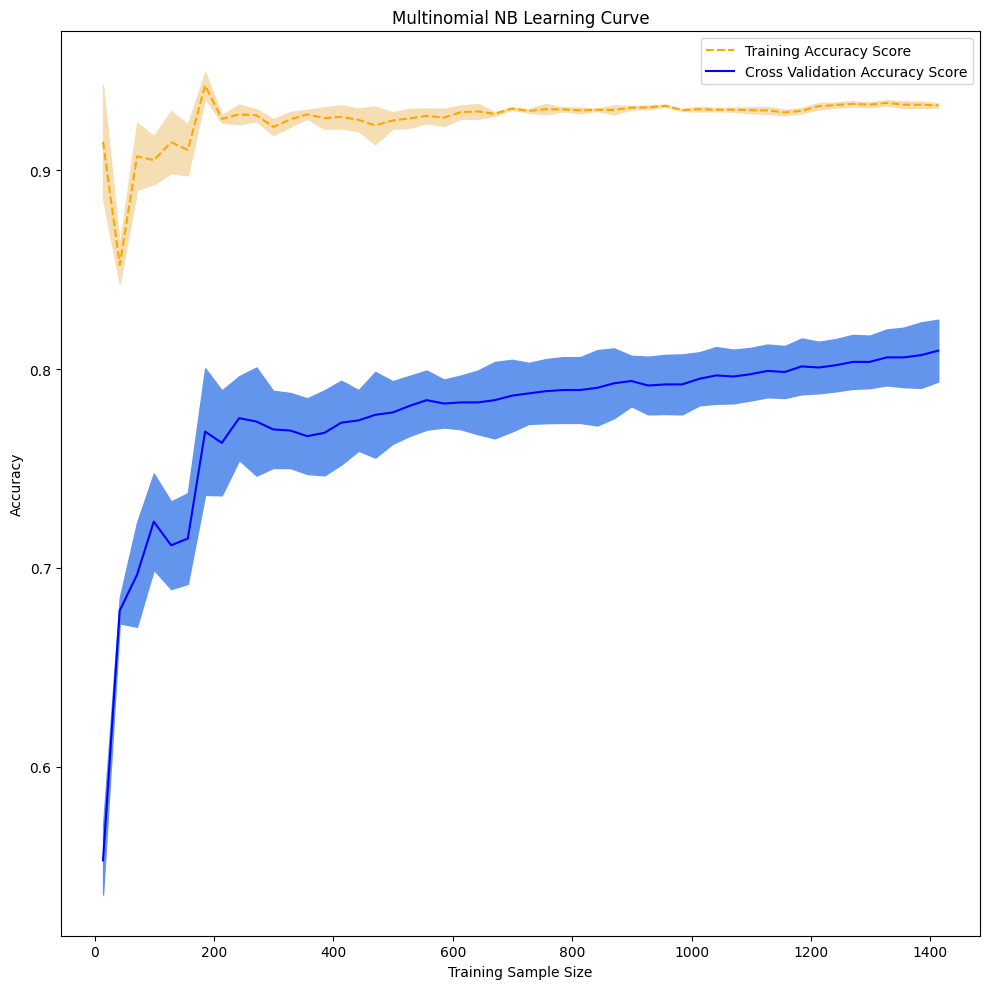

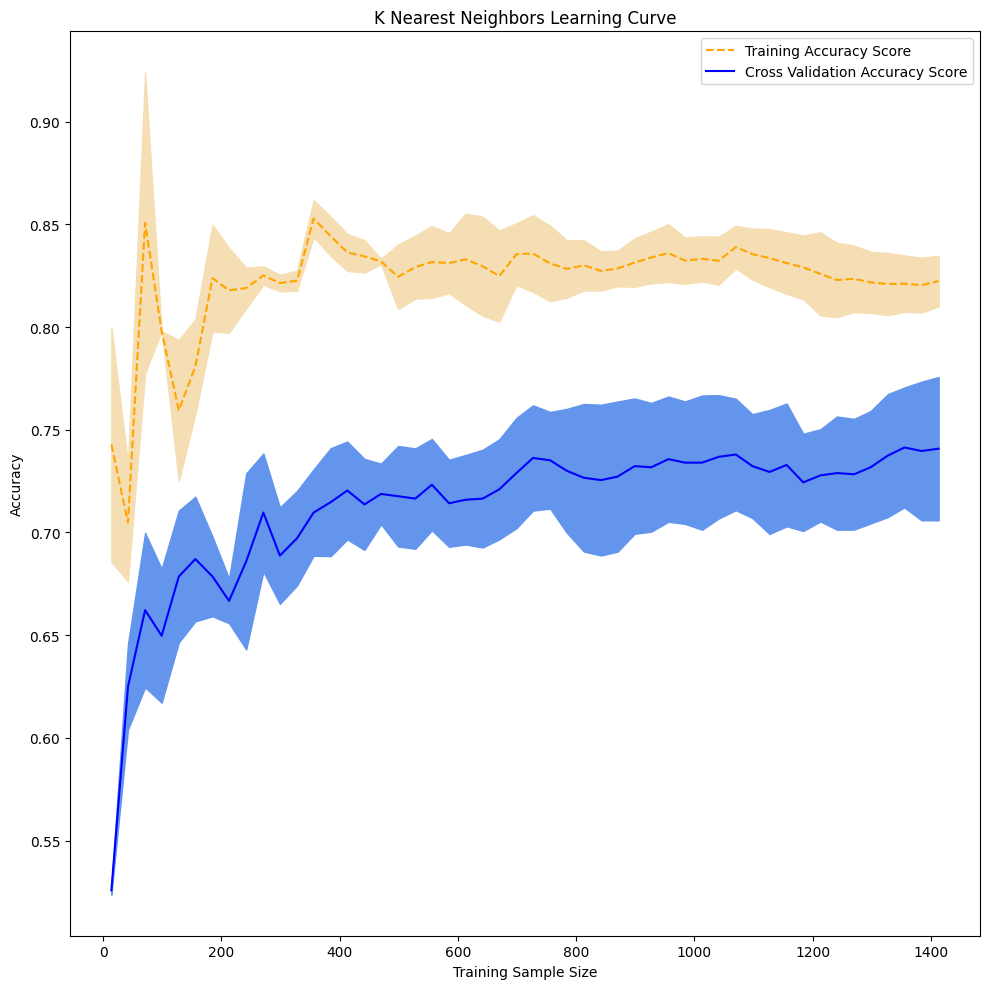

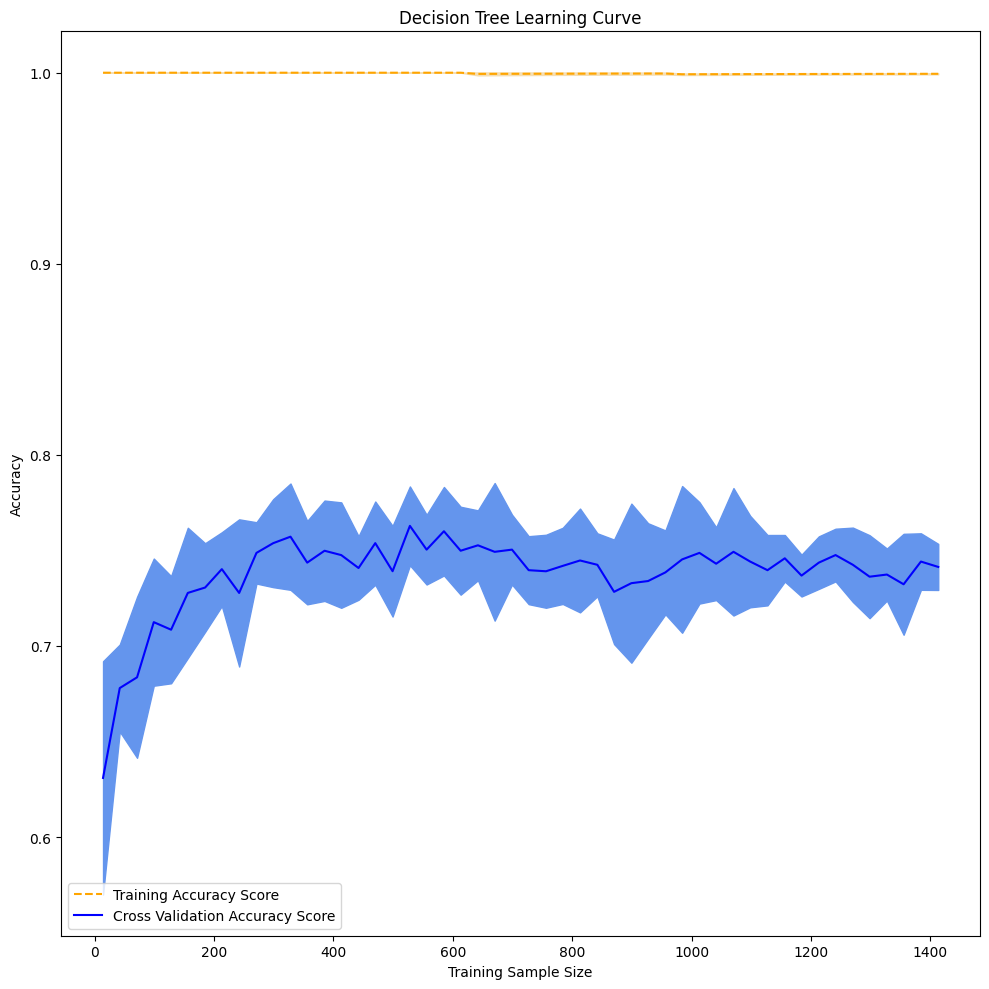

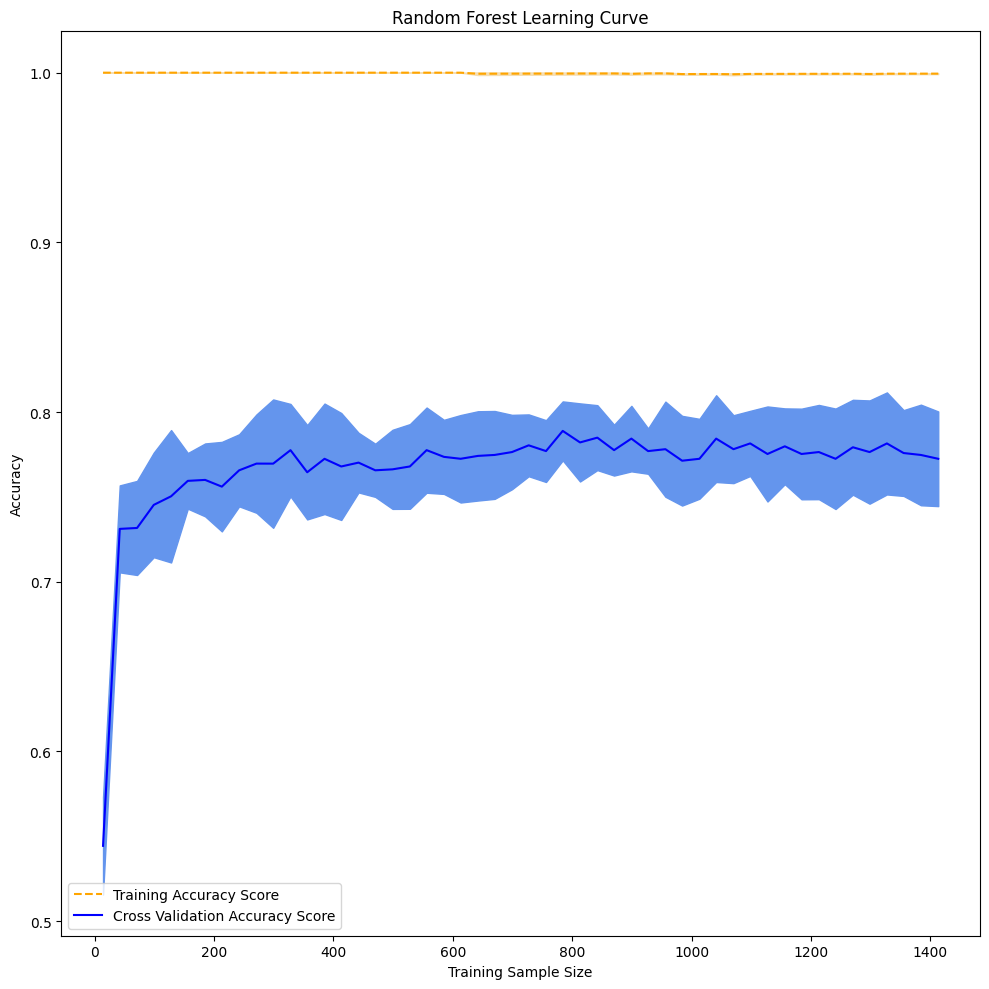

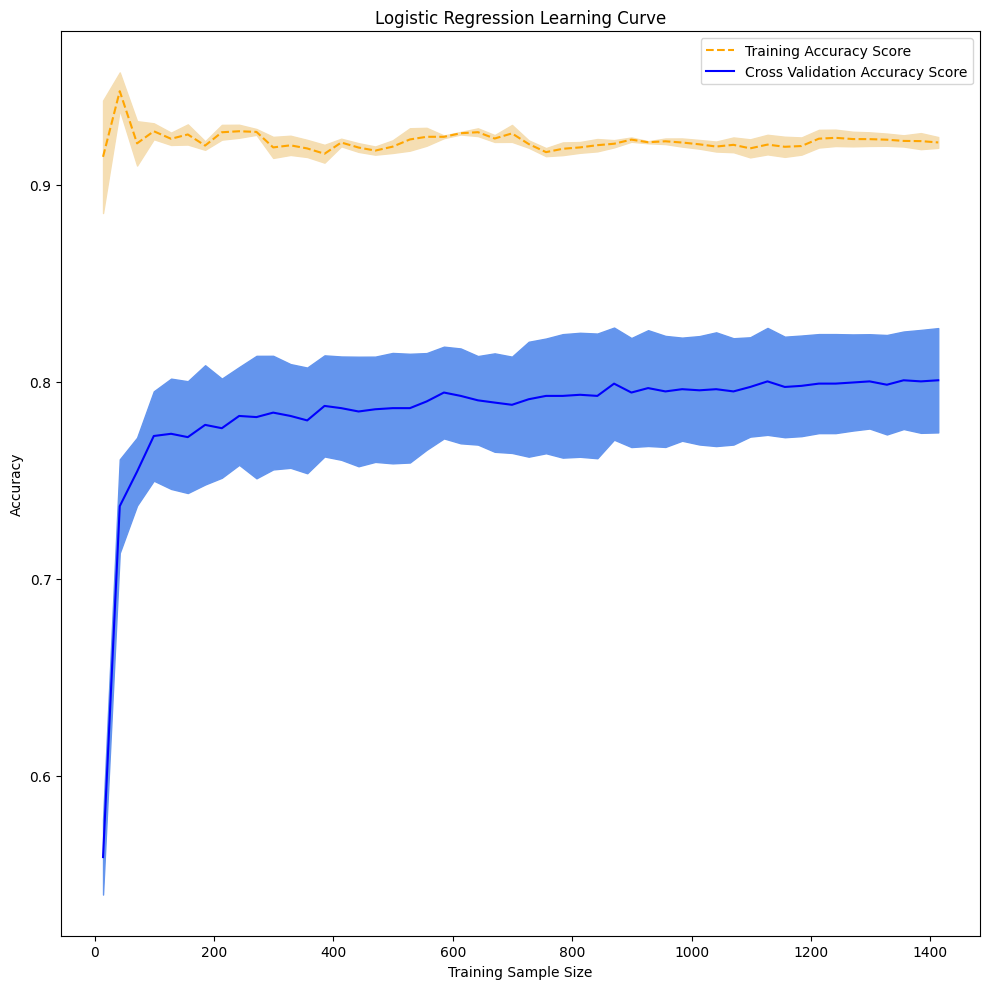

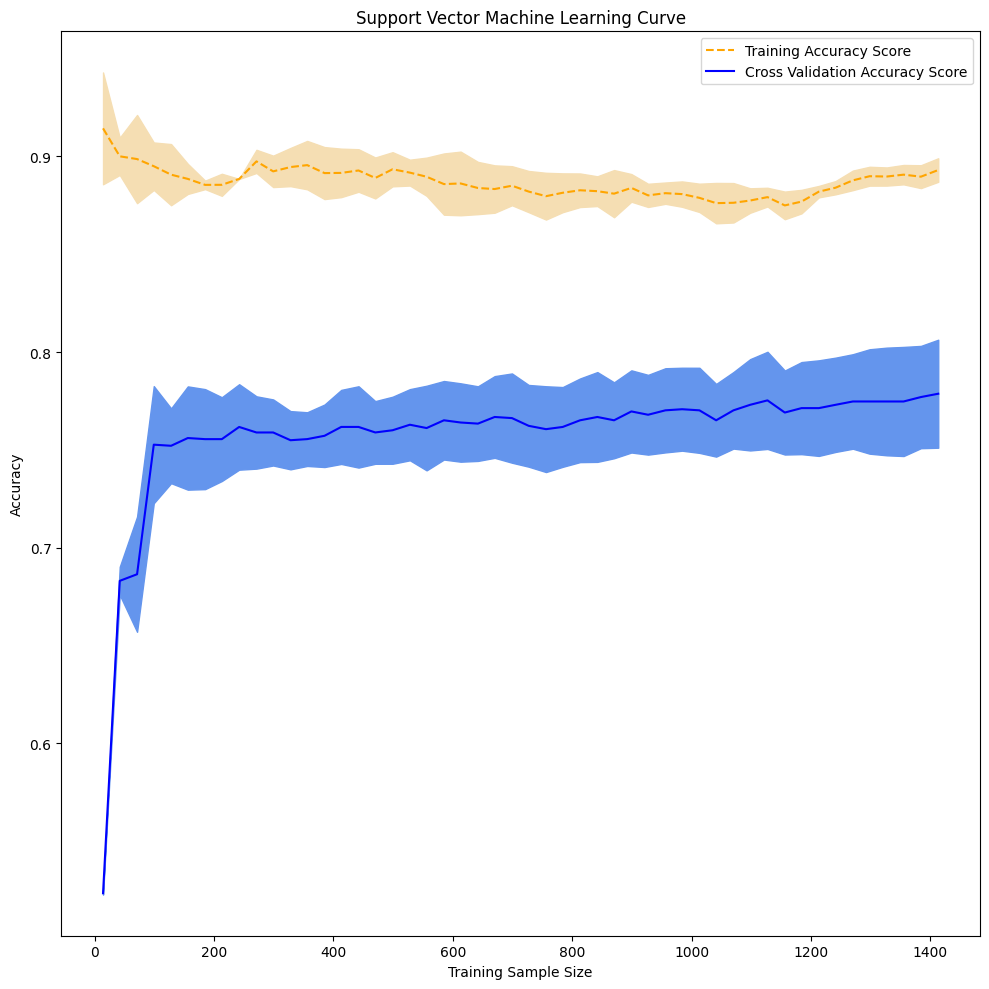

In [3]:
from sklearn.model_selection import learning_curve

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

models = {
    "Multinomial NB": MultinomialNB(),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    #"Multilayer Perceptron": MLPClassifier(max_iter=1000),
    "Support Vector Machine": SVC(),
}

for model_name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, x, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color='orange',  label='Training Accuracy Score')
    plt.plot(train_sizes, test_mean, color='blue', label='Cross Validation Accuracy Score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='wheat')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='cornflowerblue')

    plt.title(F"{model_name} Learning Curve")
    plt.xlabel("Training Sample Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.tight_layout()

    plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

model = SVC()
model_name = "Support Vector Machine"

train_sizes, train_scores, test_scores = learning_curve(model, x, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color='orange',  label='Training Accuracy Score')
plt.plot(train_sizes, test_mean, color='blue', label='Cross Validation Accuracy Score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='wheat')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='cornflowerblue')

plt.title(F"{model_name} Learning Curve")
plt.xlabel("Training Sample Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()

plt.show()

In [ ]:
feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

model.fit(x, encoded_y)

new_tweets = [""]

features = [get_features(new_tweet) for new_tweet in new_tweets]
x = []
for dictionary in features:
    values = [*dictionary.values()]
    x.append(values)
x = np.array(x)

model.predict(x)
